In [13]:
import pandas as pd
import numpy as np
import lifelines
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

# 생존 분석 모델 교차 검증 및 C-index 계산 코드 설명

## 1. 코드 목적
- **생존 분석 모델**을 교차 검증(Cross-Validation)을 통해 평가합니다.
- 각 Fold에서 **Concordance Index(C-index)**를 계산하여 모델의 성능을 비교합니다.

---

## 2. 주요 라이브러리
- `numpy` 및 `pandas`: 데이터 처리를 위해 사용.
- `sklearn.model_selection.KFold`: 교차 검증을 위한 데이터 분할.
- `lifelines` 라이브러리:
  - `CoxPHFitter`: Cox Proportional Hazards 모델 학습.
  - `KaplanMeierFitter`: 생존 곡선 모델 (현재 사용하지 않음).
  - `concordance_index`: C-index 계산을 위해 사용.
- `lifelines.datasets.load_rossi`: 예제 데이터셋 로드.

---

## 3. 함수 정의: `cross_validate_survival_models`

### 3.1. 입력 파라미터
- `data`: 분석 데이터셋 (pandas DataFrame).
- `duration_col`: 생존 시간 컬럼명 (ex. `"week"`).
- `event_col`: 이벤트 발생 여부 컬럼명 (1 = 이벤트 발생, 0 = 검열).
- `models`: 생존 분석 모델의 이름과 인스턴스 딕셔너리.
  - 예: `{"Cox Proportional Hazards": CoxPHFitter()}`
- `n_splits`: 교차 검증 Fold 수 (기본값: 5).

### 3.2. 내부 동작
1. `KFold`로 데이터를 `n_splits` 만큼 나눕니다.
2. 각 Fold에서:
   - 학습 데이터(`train_data`)로 모델 학습.
   - 검증 데이터(`test_data`)로 C-index 계산.
3. 모든 Fold에서의 C-index를 리스트에 저장.
4. 각 모델의 평균 C-index를 계산.

### 3.3. 반환값
- `results`: 각 모델의 평균 C-index 딕셔너리.
  - 예: `{"Cox Proportional Hazards": 0.75}`

---

## 4. 데이터 준비
- **데이터셋**: `lifelines.datasets.load_rossi`를 사용.
  - `week`: 생존 시간.
  - `arrest`: 이벤트 발생 여부 (1 = 이벤트 발생, 0 = 검열).

---

## 5. 사용된 생존 모델
- **Cox Proportional Hazards 모델**:
  - `lifelines.CoxPHFitter`를 사용하여 학습.

---

## 6. 코드 실행 결과
- 각 모델의 평균 C-index를 출력.

### 출력 예시
```plaintext
Cross-Validation Results (C-index):
Cox Proportional Hazards: 0.7634


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.datasets import load_rossi


# 생존 모델 교차 검증 함수 정의
def cross_validate_survival_models(data, duration_col, event_col, models, n_splits=2):
    """
    생존 분석 모델을 교차 검증하여 C-index를 계산하는 함수.

    Parameters:
    - data: pd.DataFrame, 분석 데이터셋
    - duration_col: str, 생존 시간 컬럼명
    - event_col: str, 이벤트 발생 여부 컬럼명 (1 = 이벤트 발생, 0 = 검열)
    - models: dict, 생존 분석 모델의 이름과 인스턴스 딕셔너리
    - n_splits: int, 교차 검증 Fold 수

    Returns:
    - results: dict, 각 모델의 평균 C-index
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {model_name: [] for model_name in models.keys()}

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        for model_name, model in models.items():
            # 모델 학습
            if hasattr(model, "fit"):
                model.fit(train_data, duration_col=duration_col, event_col=event_col)
            else:
                raise ValueError(f"Model {model_name} does not have a fit method.")

            # 예측 및 C-index 계산
            if hasattr(model, "predict_partial_hazard"):
                predictions = model.predict_partial_hazard(test_data)
            else:
                raise ValueError(
                    f"Model {model_name} does not support predict_partial_hazard."
                )

            c_index = concordance_index(
                test_data[duration_col],
                -predictions,  # 낮은 값이 높은 위험으로 간주되므로 부호 반전
                test_data[event_col],
            )
            results[model_name].append(c_index)

    # 각 모델의 평균 C-index 계산
    avg_results = {
        model_name: np.mean(scores) for model_name, scores in results.items()
    }
    return avg_results


# 데이터 로드
# 데이터 로드시, duration_col, event_indicator 그리고 그 이외의 독립변수들을 모두 포함한 데이터로 로드
data = pd.read_csv("C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv")
data = data[
    ["sex", "tx_1", "tx_2", "tx_3", "tx_4", "tx_5", "seer_TF", "event_inc", "stime"]
]


# 사용할 생존 분석 모델 정의
models = {
    "Cox Proportional Hazards": CoxPHFitter(),
    # 다른 모델도 추가 가능 (예: Accelerated Failure Time 모델 등)
}


# 교차 검증 수행
results = cross_validate_survival_models(
    data=data, duration_col="stime", event_col="event_inc", models=models, n_splits=5
)

# 결과 출력
print("Cross-Validation Results (C-index):")
for model_name, c_index in results.items():
    print(f"{model_name}: {c_index:.4f}")

Cross-Validation Results (C-index):
Cox Proportional Hazards: 0.7039


In [25]:
# stime 컬럼의 고유값 중 0 이하인 값 확인
unique_stime = data["stime"].unique()

for value in unique_stime:
    if value <= 0:
        print(f"0 이하 값 발견: {value}")

0 이하 값 발견: 0


# 생존 분석을 위한 변수 처리 및 분석 방법

## 1. 성별 변수(Standard Scaling 필요성)
- **성별 변수**: 1=여자, 2=남자  
  성별 변수는 **범주형 변수**로서, 숫자 값 자체에는 의미가 없기 때문에 **Standard Scaling**을 할 필요가 없습니다.
- **대안 방법**:
  - 숫자 값으로 그대로 사용하지 않고 **더미 변수화(One-Hot Encoding)** 하는 것이 적절합니다.
    ```python
    data = pd.get_dummies(data, columns=["sex"], drop_first=True)
    ```
    - `drop_first=True`를 설정하면 첫 번째 범주(여자)를 기준으로 더미 변수를 생성합니다.  
    - 결과적으로 남자(2)에 대해 `sex_2`라는 이진 변수(0, 1)가 생성됩니다.
  - **더미 변수를 사용하지 않고 그대로 입력**: Cox 모델과 같은 선형 모델에서는 그대로 입력해도 크게 문제되지 않지만 해석상 주의해야 합니다.

---

## 2. 치료 변수(tx_1, tx_2, tx_3, tx_4, tx_5) 분석 방법
- 치료 변수들은 **더미 변수화된 상태**로 보입니다.  
  예를 들어 `tx_1=1, tx_2=0, ...`인 경우는 수술만 수행한 경우를 의미합니다. 

### **분석 방법**
1. **모델 입력**:
   - 각 치료 변수(`tx_1, tx_2, ...`)를 **독립 변수**로 그대로 모델에 입력합니다.
   - `Cox 모델`의 경우 각 치료가 생존 시간에 미치는 **위험비(Hazard Ratio)**를 계산할 수 있습니다.

2. **수준별 비교**:
   - 치료가 하나만 적용된 경우(예: `tx_1=1, tx_2=tx_3=tx_4=tx_5=0`)를 기준군으로 설정하고,
   - 다른 치료 또는 복합 치료를 수행한 그룹과 비교합니다.
   - **생존 곡선**을 비교하고, 특정 치료가 생존 시간에 미치는 영향을 시각화할 수 있습니다.
     ```python
     from lifelines import KaplanMeierFitter
     import matplotlib.pyplot as plt

     kmf = KaplanMeierFitter()

     # 수술만 받은 그룹
     group1 = data[(data['tx_1'] == 1) & (data['tx_2'] == 0) & (data['tx_3'] == 0) & (data['tx_4'] == 0) & (data['tx_5'] == 0)]
     # 화학요법만 받은 그룹
     group2 = data[(data['tx_2'] == 1) & (data['tx_1'] == 0)]

     # 생존 곡선 비교
     kmf.fit(group1['stime'], event_observed=group1['event_inc'], label='Surgery Only')
     kmf.plot()
     kmf.fit(group2['stime'], event_observed=group2['event_inc'], label='Chemotherapy Only')
     kmf.plot()
     plt.title("Survival Curves by Treatment Type")
     plt.show()
     ```

3. **치료 변수의 상호작용**:
   - 여러 치료가 동시에 수행된 경우를 고려하여 **상호작용 효과**를 분석할 수 있습니다.
   - 예를 들어 `tx_1 * tx_2`와 같은 항을 추가해 모델에 입력합니다.

4. **변수 선택**:
   - Lasso 정규화를 사용해 중요도가 높은 치료 변수를 선택할 수 있습니다.

---

## 3. 전이 여부 변수(seer_TF) 분석 방법
- `seer_TF`: 1=전이O, 0=전이X  
  **전이 여부**는 이진 변수이며 생존 시간에 중요한 영향을 미칠 수 있는 **주요 예측 변수**입니다.

### **분석 방법**
1. **Cox 모델에서 사용**:
   - 전이 여부를 **독립 변수**로 모델에 포함합니다.
   - **Hazard Ratio**를 통해 전이 여부가 생존 시간에 미치는 위험도를 평가할 수 있습니다.
     ```python
     cph = CoxPHFitter()
     cph.fit(data, duration_col="stime", event_col="event_inc")
     cph.print_summary()  # seer_TF의 Hazard Ratio 확인
     ```

2. **Kaplan-Meier 생존 곡선 비교**:
   - 전이 여부에 따라 생존 곡선을 비교합니다.
     ```python
     kmf = KaplanMeierFitter()

     # 전이O 그룹
     group1 = data[data['seer_TF'] == 1]
     kmf.fit(group1['stime'], event_observed=group1['event_inc'], label='Metastasis (Yes)')
     kmf.plot()

     # 전이X 그룹
     group2 = data[data['seer_TF'] == 0]
     kmf.fit(group2['stime'], event_observed=group2['event_inc'], label='Metastasis (No)')
     kmf.plot()

     plt.title("Survival Curves by Metastasis Status")
     plt.show()
     ```

3. **전이 여부와 다른 변수의 상호작용 분석**:
   - 전이가 되었는지 여부와 치료 방법(`tx_1 ~ tx_5`) 사이의 상호작용을 추가해 모델에 포함합니다.
   - 예: `seer_TF * tx_1` 항목을 추가.

---

## **요약**
1. **성별**: 더미 변수화(One-Hot Encoding) 적용.
2. **치료 변수**:
   - 개별 변수로 사용해 생존 시간에 미치는 영향 평가.
   - 생존 곡선을 통해 치료별 비교.
   - 상호작용 효과 분석 가능.
3. **전이 여부(seer_TF)**:
   - 생존 곡선으로 그룹 비교.
   - Cox 모델에서 주요 예측 변수로 사용.
   - 다른 변수와의 상호작용 항 추가 분석.


In [7]:
## standard scaler 적용시의 값 확인해보기
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = data[['sex', 'tx_1', 'tx_2', 'tx_3', 'tx_4', 'tx_5', 'seer_TF']]
# X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# X_scaled

,sex,tx_1,tx_2,tx_3,tx_4,tx_5,seer_TF
0,1.210842,0.518645,1.298485,-0.293047,-0.114147,-0.019564,0.786903
1,1.210842,0.518645,1.298485,-0.293047,-0.114147,-0.019564,-1.270805
2,-0.825871,0.518645,1.298485,-0.293047,-0.114147,-0.019564,-1.270805
3,-0.825871,0.518645,1.298485,-0.293047,-0.114147,-0.019564,0.786903
4,1.210842,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,-1.270805
...,...,...,...,...,...,...,...
33971,-0.825871,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,0.786903
33972,-0.825871,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,0.786903
33973,-0.825871,0.518645,-0.770129,-0.293047,-0.114147,-0.019564,-1.270805
33974,-0.825871,0.518645,1.298485,-0.293047,-0.114147,-0.019564,0.786903


In [9]:
### '구' 로 클러스터를 나누었을때, 각각의 클러스터에 속한 값들의 갯수 확인
# data = pd.read_csv('C:/Users/user/Desktop/Survival_Data/DISEASE/colon.csv')
# data['gu'].value_counts()

gu
해운대구    3705
부산진구    3690
사하구     3209
남구      3147
북구      2654
연제구     2554
동래구     2458
금정구     2420
사상구     2033
수영구     1831
영도구     1455
서구      1342
동구      1244
기장군     1046
강서구      655
중구       533
Name: count, dtype: int64

# 부산시 대장암(악성종양) 데이터 분석

In [ ]:
import survival_analysis_v2 as sa
import pandas as pd


data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"

event_col = "event_inc"

frailty_col = "gu_encoded"

# Preprocess data

data = data[
    [
        "age",
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]

data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

data.head()

,age,stime,event_inc,tx_1,tx_2,tx_3,tx_4,tx_5,seer_TF,gu_encoded
0,66,64.0,1,1,1,0,0,0,1,1
1,46,298.0,0,1,1,0,0,0,0,10
2,64,241.0,1,1,1,0,0,0,0,13
3,47,104.0,1,1,1,0,0,0,1,8
4,57,296.0,0,1,0,0,0,0,0,15
5,56,116.0,1,1,1,1,0,0,1,5
6,62,47.0,1,1,1,1,0,0,1,10
7,42,166.0,1,1,1,0,0,0,0,9
8,42,166.0,1,1,1,0,0,0,0,9
9,55,110.0,1,1,1,0,0,0,1,3


,age,stime
age,1.000000,-0.079726
stime,-0.079726,1.000000


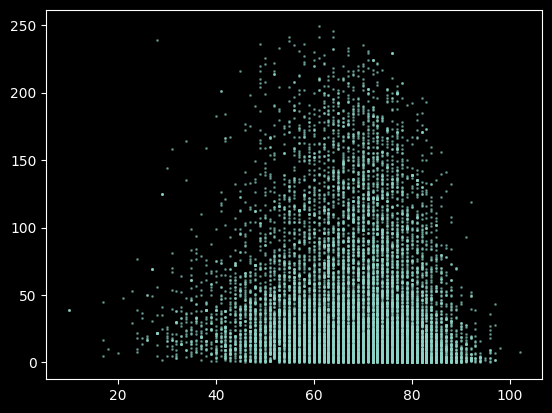

In [4]:
import matplotlib.pyplot as plt

# 나이에 따른 생존시간.
age = data[data["event_inc"] == 1]["age"]
stime = data[data["event_inc"] == 1]["stime"]
plt.scatter(age, stime, alpha=0.5, s=1)

# age & stime 상관관계 분석 (event_inc == 1 인 경우만)
age_stime_event_corr = pd.concat([age, stime], axis=1)
age_stime_event_corr.corr()
# corr = -0.079726 : 나이와 생존시간은 상관관계가 없다.

,normalized_age,normalized_stime
normalized_age,1.000000,-0.079726
normalized_stime,-0.079726,1.000000


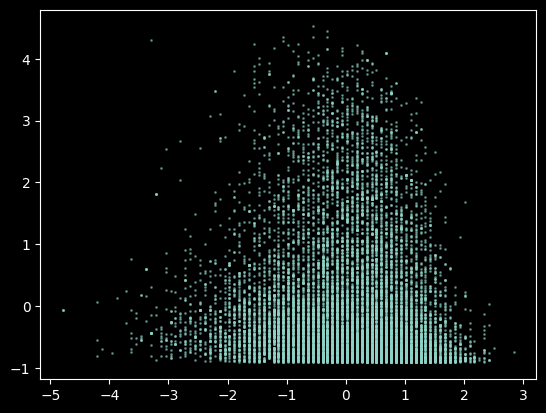

In [11]:
# 나이 스케일링(standard scaler)
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
normalized_age = scaler.fit_transform(age.values.reshape(-1, 1))
normalized_stime = scaler.fit_transform(stime.values.reshape(-1, 1))

plt.scatter(normalized_age, normalized_stime, alpha=0.5, s=1)  # 스케일링 후 산점도

# 스케일링 이후의 상관관계 분석
age_stime_event_corr = pd.DataFrame(
    np.hstack((normalized_age, normalized_stime)),
    columns=["normalized_age", "normalized_stime"],
)
age_stime_event_corr.corr()
# corr = -0.079726 : 나이와 생존시간은 상관관계가 없다.

### 전이유무에 따른 생존율

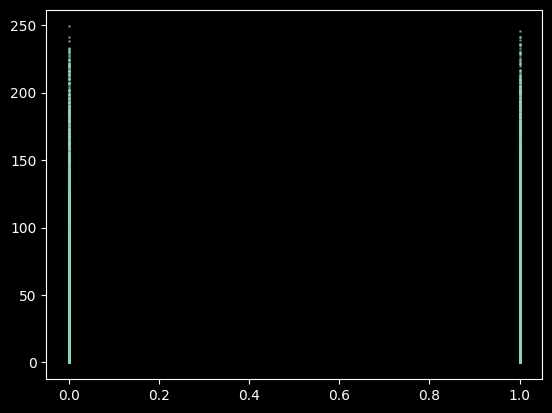

In [13]:
seer_TF = data[data["event_inc"] == 1]["seer_TF"]
plt.scatter(seer_TF, stime, alpha=0.5, s=1)

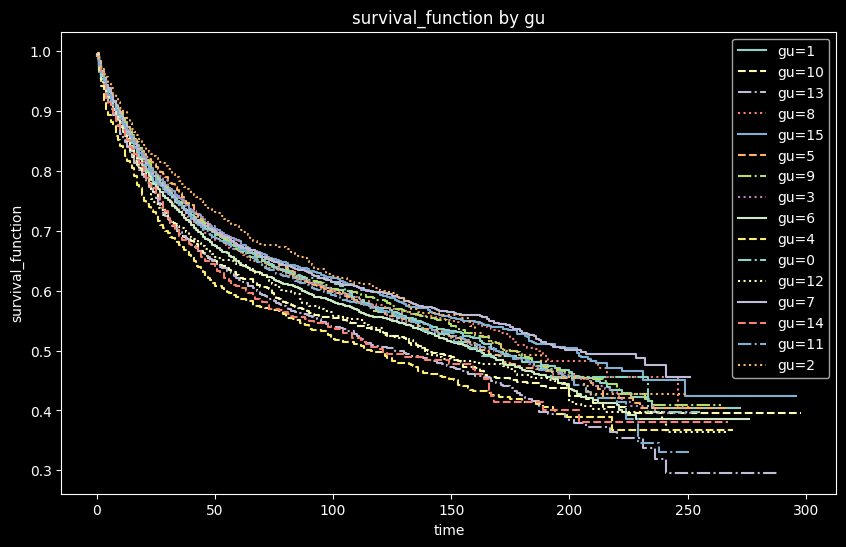

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 데이터 로드
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

# kmf 불러오기
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

linestyles = ["-", "--", "-.", ":"]

# 지역별 생존분석
for i, gu in enumerate(data["gu_encoded"].unique()):
    subset = data[data["gu_encoded"] == gu]
    kmf.fit(subset["stime"], subset["event_inc"], label=f"gu={gu}")
    kmf.plot_survival_function(
        ci_show=False,  # 신뢰구간 제거
        linestyle=linestyles[i % len(linestyles)],  # 선 스타일 지정
        linewidth=1.5,
    )  # 선 두께께

plt.title("survival_function by gu")
plt.xlabel("time")
plt.ylabel("survival_function")
plt.show()

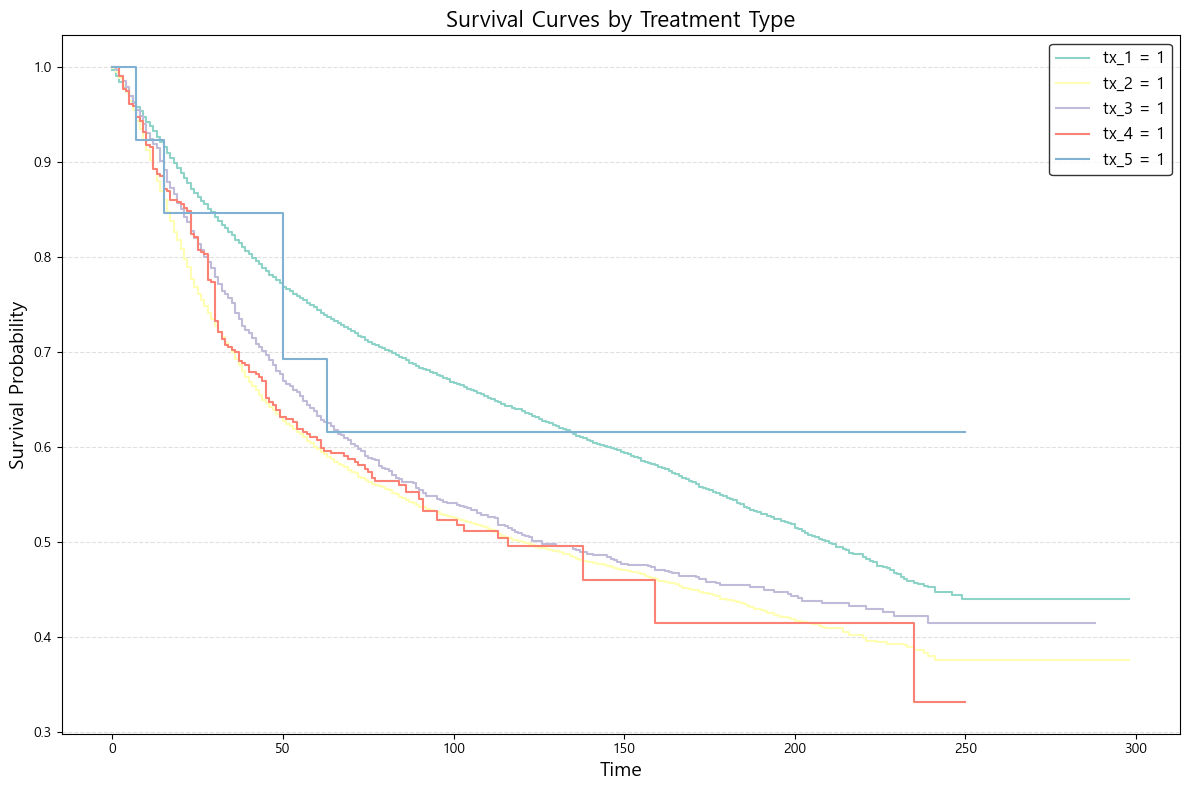

In [29]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"
event_col = "event_inc"
frailty_col = "gu_encoded"

data = data[['event_inc','tx_1','tx_2','tx_3','tx_4','tx_5','seer_TF','gu_encoded','stime']]

# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

# Plot survival curves for each treatment variable
plt.figure(figsize=(12, 8), facecolor="white")  # 전체 배경을 하얗게 설정

for tx in ["tx_1", "tx_2", "tx_3", "tx_4", "tx_5"]:
    kmf.fit(
        data[data[tx] == 1][duration_col],
        event_observed=data[data[tx] == 1][event_col],
        label=f"{tx} = 1",
    )
    kmf.plot_survival_function(ci_show=False)

# 축 테두리 색상 설정
ax = plt.gca()  # 현재 축 가져오기
ax.spines["bottom"].set_color("black")  # 아래쪽 X축 테두리 색상
ax.spines["left"].set_color("black")  # 왼쪽 Y축 테두리 색상
ax.spines["top"].set_color("black")  # 위쪽 테두리 색상
ax.spines["right"].set_color("black")  # 오른쪽 테두리 색상

# 눈금 색상 설정
ax.tick_params(axis="x", colors="black")  # X축 눈금 색상
ax.tick_params(axis="y", colors="black")  # Y축 눈금 색상

# 제목과 축 레이블 설정
plt.title("Survival Curves by Treatment Type", color="black", fontsize=16)
plt.xlabel("Time", color="black", fontsize=14)
plt.ylabel("Survival Probability", color="black", fontsize=14)

# 범례 설정
plt.legend(facecolor="white", edgecolor="black", fontsize=12)  # 범례 배경과 테두리 설정

# 격자선 설정
plt.grid(axis="y", linestyle="--", color="lightgray", alpha=0.7)

# 레이아웃 및 출력
plt.tight_layout()
plt.show()

### Cox-PH model

In [3]:
# Initialize CoxPHModel

coxph = sa.CoxPHModel(duration_col=duration_col, event_col=event_col)

# fit the model
coxph.fit(data)

# predict
coxph.predict(data)

# summary
coxph.summary()

<lifelines.CoxPHFitter: fitted with 33976 total observations, 19331 right-censored observations>
             duration col = 'stime'
                event col = 'event_inc'
      baseline estimation = breslow
   number of observations = 33976
number of events observed = 14645
   partial log-likelihood = -142382.09
         time fit was run = 2025-01-03 02:38:39 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
tx_1       -1.32      0.27      0.02           -1.36           -1.29                0.26                0.28
tx_2       -0.13      0.88      0.02           -0.17           -0.10                0.85                0.91
tx_3       -0.43      0.65      0.03           -0.49           -0.37                0.61                0.69
tx_4        0.03      1.03      0.07           -0.11            0.17                0.90                1.19
tx_5       -0.49      0.61      0.45           -1.37            0.39                0.25                1.47
seer_TF     1.11      3.02      0.02            1.06            1.15                2.90                3.15
gu_encoded  0.00      1.00      0.00           -0.00            0.00                1.00                1.00

            cmp to      z      p  -log2(p)
covariate                                 
tx_1          0.00 -73.65 <0.005       inf
tx_2          0.00  -7.15 <0.005     40.10
tx_3          0.00 -13.76 <0.005    140.70
tx_4          0.00   0.41   0.68      0.55
tx_5          0.00  -1.09   0.27      1.87
seer_TF       0.00  52.85 <0.005       inf
gu_encoded    0.00   0.23   0.82      0.29
---
Concordance = 0.70
Partial AIC = 284778.19
log-likelihood ratio test = 7292.52 on 7 df
-log2(p) of ll-ratio test = inf

In [ ]:
coxph.plot()

cox proportional hazards model C-index : 0.7012889832146106


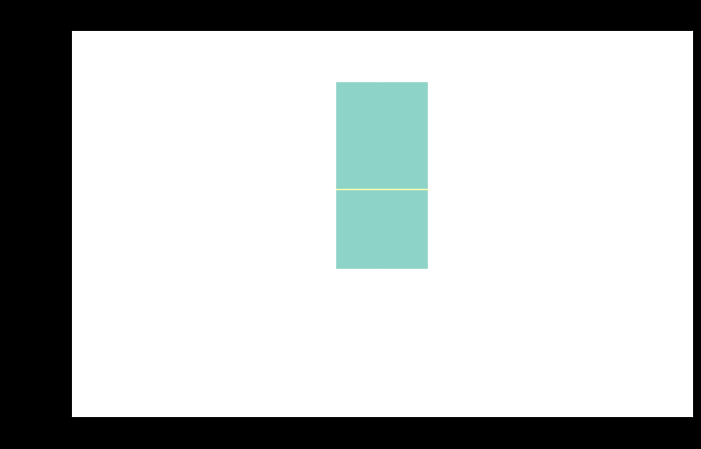

In [17]:
# Cox-PH model 에 cross validation 적용 + C-index 계산 및 결과

# library import
import survival_analysis_v2 as sa
import pandas as pd
import numpy as np

# data load
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"

event_col = "event_inc"

frailty_col = "gu_encoded"

# Preprocess data
# 위의 과정에서 나이와 생존시간의 상관관계가 없다는 것을 확인하였으므로, 나이는 배제함.
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]

data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

data.head()

# cross validation
cv = sa.CrossValidator(data, duration_col, event_col)

# Cox Proportional Hazards Model
cox_c_indices = cv.cross_validate(sa.CoxPHModel)

# 결과 출력
print("cox proportional hazards model C-index :", np.mean(cox_c_indices))

# 결과 시각화
cv.plot_c_index(cox_c_indices, "Cox Proportional Hazards")

### Cox Ridge(L1_ration=0.0) & Cox Lasso(L1_ration = 0.1)

Cox Proportional Hazards with Ridge (L2) C-index: 0.7013787387531878


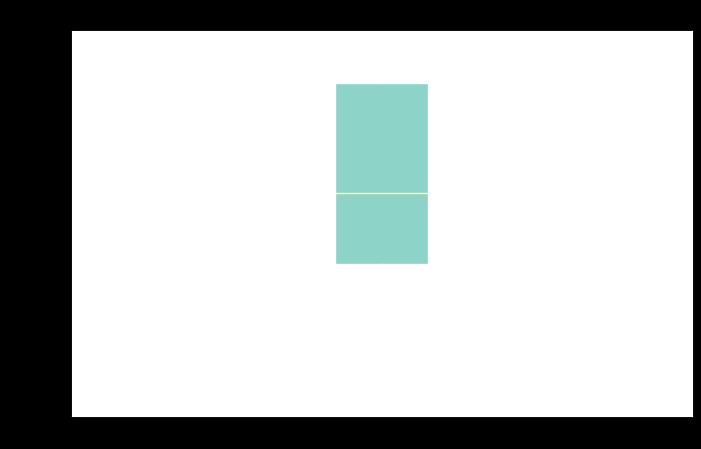

Cox Proportional Hazards with Lasso (L1) C-index: 0.6945259520136963


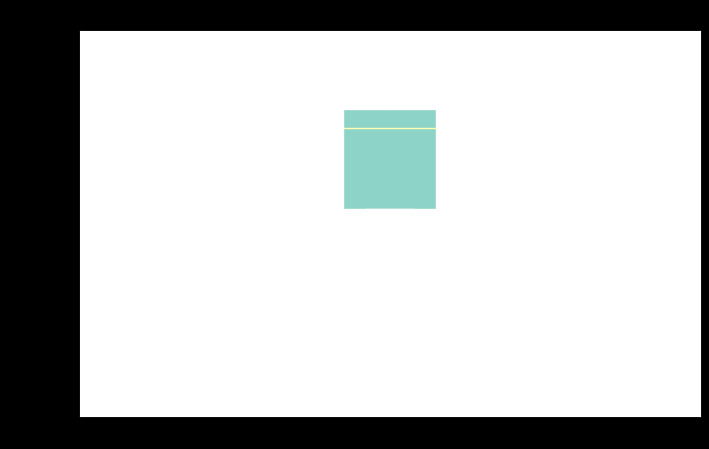

In [18]:
# Ridge와 Lasso를 사용한 Cox Proportional Hazards Model

# library import
import survival_analysis_v2 as sa
import pandas as pd
import numpy as np

# 데이터 로드
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"
event_col = "event_inc"

# 데이터 전처리
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]
data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

# CrossValidator 객체 생성
cv = sa.CrossValidator(data, duration_col, event_col)

# Ridge 적용 (l1_ratio=0.0, L2 규제)
ridge_c_indices = cv.cross_validate(sa.CoxPHModel, penalizer=0.1, l1_ratio=0.0)
print("Cox Proportional Hazards with Ridge (L2) C-index:", np.mean(ridge_c_indices))
cv.plot_c_index(ridge_c_indices, "Cox Proportional Hazards (Ridge)")

# Lasso 적용 (l1_ratio=1.0, L1 규제)
lasso_c_indices = cv.cross_validate(sa.CoxPHModel, penalizer=0.1, l1_ratio=1.0)
print("Cox Proportional Hazards with Lasso (L1) C-index:", np.mean(lasso_c_indices))
cv.plot_c_index(lasso_c_indices, "Cox Proportional Hazards (Lasso)")


### weibull aft model

In [19]:
# initialize the model
weibull_aft = sa.WeibullAFTModel(duration_col=duration_col, event_col=event_col)

# fit the model
weibull_aft.fit(data)

# predict
weibull_aft.predict(data)

# summary
weibull_aft.summary()

<lifelines.WeibullAFTFitter: fitted with 33976 total observations, 19331 right-censored observations>
             duration col = 'stime'
                event col = 'event_inc'
   number of observations = 33976
number of events observed = 14645
           log-likelihood = -85595.23
         time fit was run = 2025-01-06 02:07:45 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                   
lambda_ gu_encoded -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
        seer_TF    -1.61      0.20      0.03           -1.67           -1.55                0.19                0.21
        tx_1        1.92      6.80      0.03            1.86            1.97                6.45                7.17
        tx_2        0.17      1.19      0.03            0.12            0.22                1.13                1.25
        tx_3        0.61      1.84      0.05            0.52            0.70                1.68                2.01
        tx_4       -0.09      0.91      0.10           -0.30            0.11                0.74                1.11
        tx_5        0.74      2.09      0.65           -0.53            2.00                0.59                7.43
        Intercept   5.01    149.33      0.04            4.93            5.08              139.02              160.39
rho_    Intercept  -0.37      0.69      0.01           -0.38           -0.36                0.68                0.70

                    cmp to      z      p  -log2(p)
param   covariate                                 
lambda_ gu_encoded    0.00  -0.20   0.84      0.25
        seer_TF       0.00 -51.32 <0.005       inf
        tx_1          0.00  70.43 <0.005       inf
        tx_2          0.00   6.42 <0.005     32.80
        tx_3          0.00  13.42 <0.005    134.02
        tx_4          0.00  -0.91   0.36      1.47
        tx_5          0.00   1.14   0.26      1.97
        Intercept     0.00 137.24 <0.005       inf
rho_    Intercept     0.00 -52.23 <0.005       inf
---
Concordance = 0.70
AIC = 171208.45
log-likelihood ratio test = 7369.14 on 7 df
-log2(p) of ll-ratio test = inf

In [20]:
weibull_aft.plot()

AttributeError: 'WeibullAFTModel' object has no attribute 'plot'

Weibull AFT model C-index : 0.2986445843026893


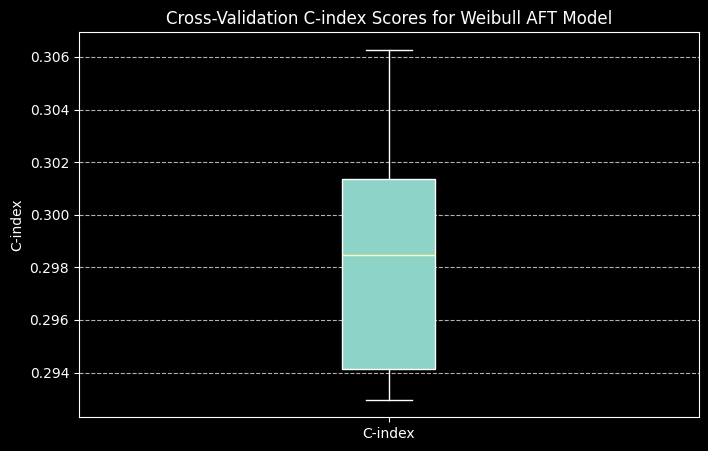

In [6]:
# Weibull AFT model 에 cross validation 적용 + C-index 계산 및 결과

# library import
import survival_analysis_v2 as sa
import pandas as pd
import numpy as np

# data load
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"

event_col = "event_inc"

frailty_col = "gu_encoded"

# Preprocess data
# 위의 과정에서 나이와 생존시간의 상관관계가 없다는 것을 확인하였으므로, 나이는 배제함.
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]

data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

data.head()

# cross validation
cv_weibullaft = sa.CrossValidator(data, duration_col, event_col)

# Cox Proportional Hazards Model
weibull_c_indices = cv_weibullaft.cross_validate(sa.WeibullAFTModel)

# 결과 출력
print("Weibull AFT model C-index :", np.mean(weibull_c_indices))

# 결과 시각화
cv.plot_c_index(weibull_c_indices, "Weibull AFT Model")

### Log normal aft model

In [9]:
# initialize the model
lognormal_aft = sa.LogNormalAFTModel(duration_col=duration_col, event_col=event_col)

# fit the model
lognormal_aft.fit(data)

# predict
lognormal_aft.predict(data)

# summary
lognormal_aft.summary()

<lifelines.LogNormalAFTFitter: fitted with 33976 total observations, 19331 right-censored observations>
             duration col = 'stime'
                event col = 'event_inc'
   number of observations = 33976
number of events observed = 14645
           log-likelihood = -85621.08
         time fit was run = 2025-01-02 15:52:51 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                   
mu_    gu_encoded -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
       seer_TF    -1.74      0.18      0.03           -1.80           -1.67                0.16                0.19
       tx_1        2.29      9.84      0.03            2.22            2.35                9.24               10.47
       tx_2        0.42      1.53      0.03            0.36            0.48                1.44                1.62
       tx_3        0.58      1.79      0.05            0.48            0.68                1.61                1.98
       tx_4        0.06      1.07      0.12           -0.17            0.30                0.84                1.35
       tx_5        0.52      1.69      0.70           -0.85            1.90                0.43                6.69
       Intercept   4.21     67.46      0.04            4.13            4.29               62.10               73.29
sigma_ Intercept   0.77      2.16      0.01            0.76            0.78                2.13                2.19

                   cmp to      z      p  -log2(p)
param  covariate                                 
mu_    gu_encoded    0.00  -0.23   0.82      0.29
       seer_TF       0.00 -53.01 <0.005       inf
       tx_1          0.00  71.62 <0.005       inf
       tx_2          0.00  13.48 <0.005    135.22
       tx_3          0.00  11.12 <0.005     93.05
       tx_4          0.00   0.52   0.60      0.73
       tx_5          0.00   0.74   0.46      1.13
       Intercept     0.00  99.66 <0.005       inf
sigma_ Intercept     0.00 121.69 <0.005       inf
---
Concordance = 0.70
AIC = 171260.16
log-likelihood ratio test = 7727.72 on 7 df
-log2(p) of ll-ratio test = inf

In [ ]:
lognormal_aft.plot()

Weibull AFT model C-index : 0.2986445843026893


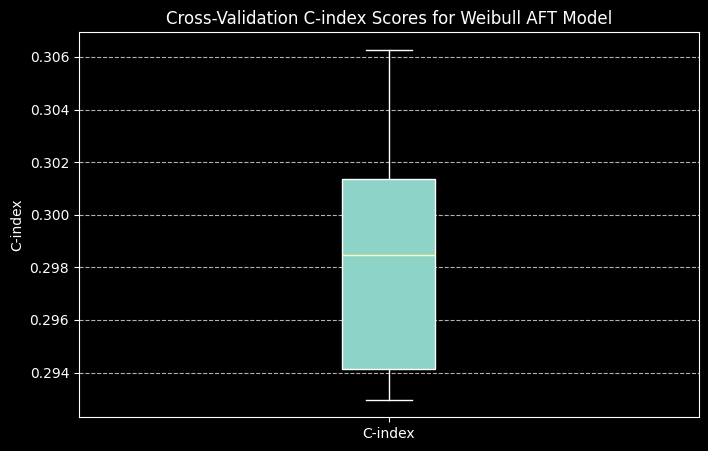

In [7]:
# lognormal AFT model 에 cross validation 적용 + C-index 계산 및 결과

# library import
import survival_analysis_v2 as sa
import pandas as pd
import numpy as np

# data load
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"

event_col = "event_inc"

frailty_col = "gu_encoded"

# Preprocess data
# 위의 과정에서 나이와 생존시간의 상관관계가 없다는 것을 확인하였으므로, 나이는 배제함.
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]

data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

data.head()

# cross validation
cv_lognormalaft = sa.CrossValidator(data, duration_col, event_col)

# Cox Proportional Hazards Model
lognormal_c_indices = cv_lognormalaft.cross_validate(sa.LogNormalAFTModel)

# 결과 출력
print("lognormal AFT model C-index :", np.mean(lognormal_c_indices))

# 결과 시각화
cv.plot_c_index(lognormal_c_indices, "lognormal Model")

### strata - Cox-PH model

In [22]:
# initialize the model
frailty = sa.Frailty(
    duration_col=duration_col, event_col=event_col, strata_col=frailty_col
)

# fit the model
frailty.fit(data)

# predict
frailty.predict(data)

# summary
frailty.summary()

<lifelines.CoxPHFitter: fitted with 33976 total observations, 19331 right-censored observations>
             duration col = 'stime'
                event col = 'event_inc'
                   strata = gu_encoded
      baseline estimation = breslow
   number of observations = 33976
number of events observed = 14645
   partial log-likelihood = -103370.16
         time fit was run = 2025-01-06 02:08:11 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tx_1      -1.32      0.27      0.02           -1.36           -1.29                0.26                0.28
tx_2      -0.13      0.88      0.02           -0.17           -0.09                0.85                0.91
tx_3      -0.43      0.65      0.03           -0.49           -0.37                0.61                0.69
tx_4       0.02      1.02      0.07           -0.12            0.16                0.89                1.17
tx_5      -0.50      0.61      0.45           -1.38            0.38                0.25                1.46
seer_TF    1.10      3.00      0.02            1.06            1.14                2.88                3.13

           cmp to      z      p  -log2(p)
covariate                                
tx_1         0.00 -73.48 <0.005       inf
tx_2         0.00  -6.97 <0.005     38.23
tx_3         0.00 -13.78 <0.005    141.16
tx_4         0.00   0.27   0.79      0.35
tx_5         0.00  -1.12   0.26      1.93
seer_TF      0.00  52.45 <0.005       inf
---
Concordance = 0.70
Partial AIC = 206752.32
log-likelihood ratio test = 7238.70 on 6 df
-log2(p) of ll-ratio test = inf

In [23]:
frailty.plot()

AttributeError: 'Frailty' object has no attribute 'plot'

frailty model C-index : 0.7021025220146981


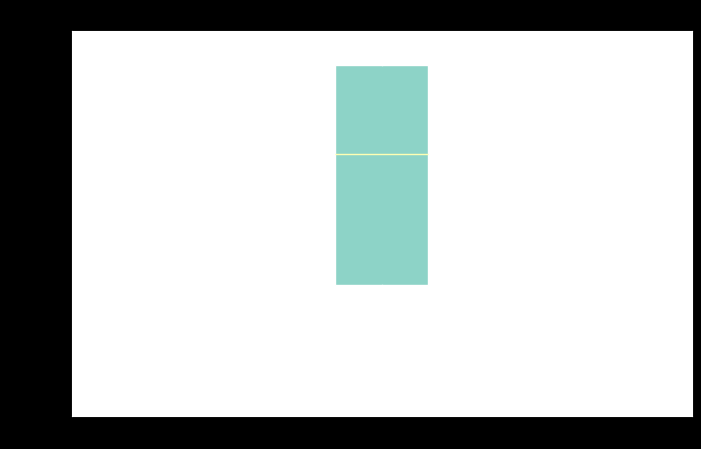

In [24]:
# Frailty model 에 cross validation 적용 + C-index 계산 및 결과

# library import
import survival_analysis_v2 as sa
import pandas as pd
import numpy as np

# data load
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)

duration_col = "stime"

event_col = "event_inc"

frailty_col = "gu_encoded"

# Preprocess data
# 위의 과정에서 나이와 생존시간의 상관관계가 없다는 것을 확인하였으므로, 나이는 배제함.
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]

data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

data.head()

# cross validation
cv_frailty = sa.CrossValidator(data, duration_col, event_col)

# Cox Proportional Hazards Model
frailty_c_indices = cv_frailty.cross_validate(sa.Frailty, strata_col=frailty_col)

# 결과 출력
print("frailty model C-index :", np.mean(frailty_c_indices))

# 결과 시각화
cv.plot_c_index(frailty_c_indices, "frailty Model")

### Random Survival Forest

Random Survival Forest model C-index: 0.2958866710843111


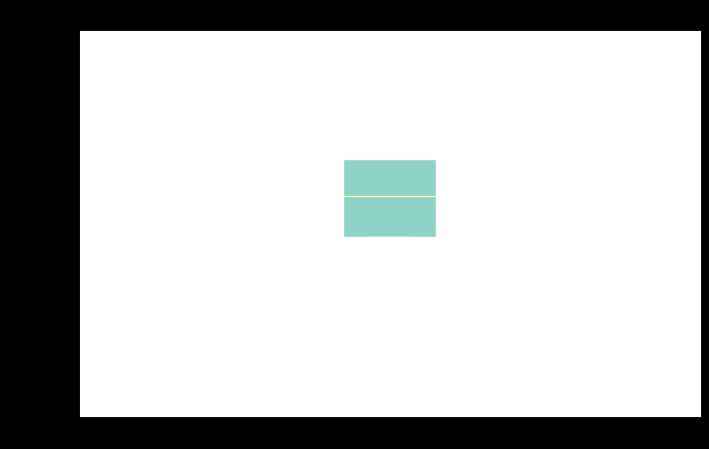

In [25]:
# Import required libraries
import survival_analysis_v2 as sa
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv("C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0)
duration_col = "stime"
event_col = "event_inc"

# Preprocess data
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]
data["stime"] = data["stime"].apply(lambda x: 0.01 if x <= 0 else x)

# Cross-validation
cv_rsf = sa.CrossValidator(data, duration_col, event_col)

# Random Survival Forest Model 적용
rsf_c_indices = cv_rsf.cross_validate(
    sa.RandomSurvivalForestModel,  # RSF 모델 클래스
    n_splits=5,
    n_estimators=200,  # RSF 모델의 파라미터
    random_state=42,
)

# 결과 출력
print("Random Survival Forest model C-index:", np.mean(rsf_c_indices))

# 결과 시각화
cv_rsf.plot_c_index(rsf_c_indices, "Random Survival Forest")

### C-index PLOT

C:\Users\user\AppData\Local\Temp\ipykernel_21820\1086275567.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


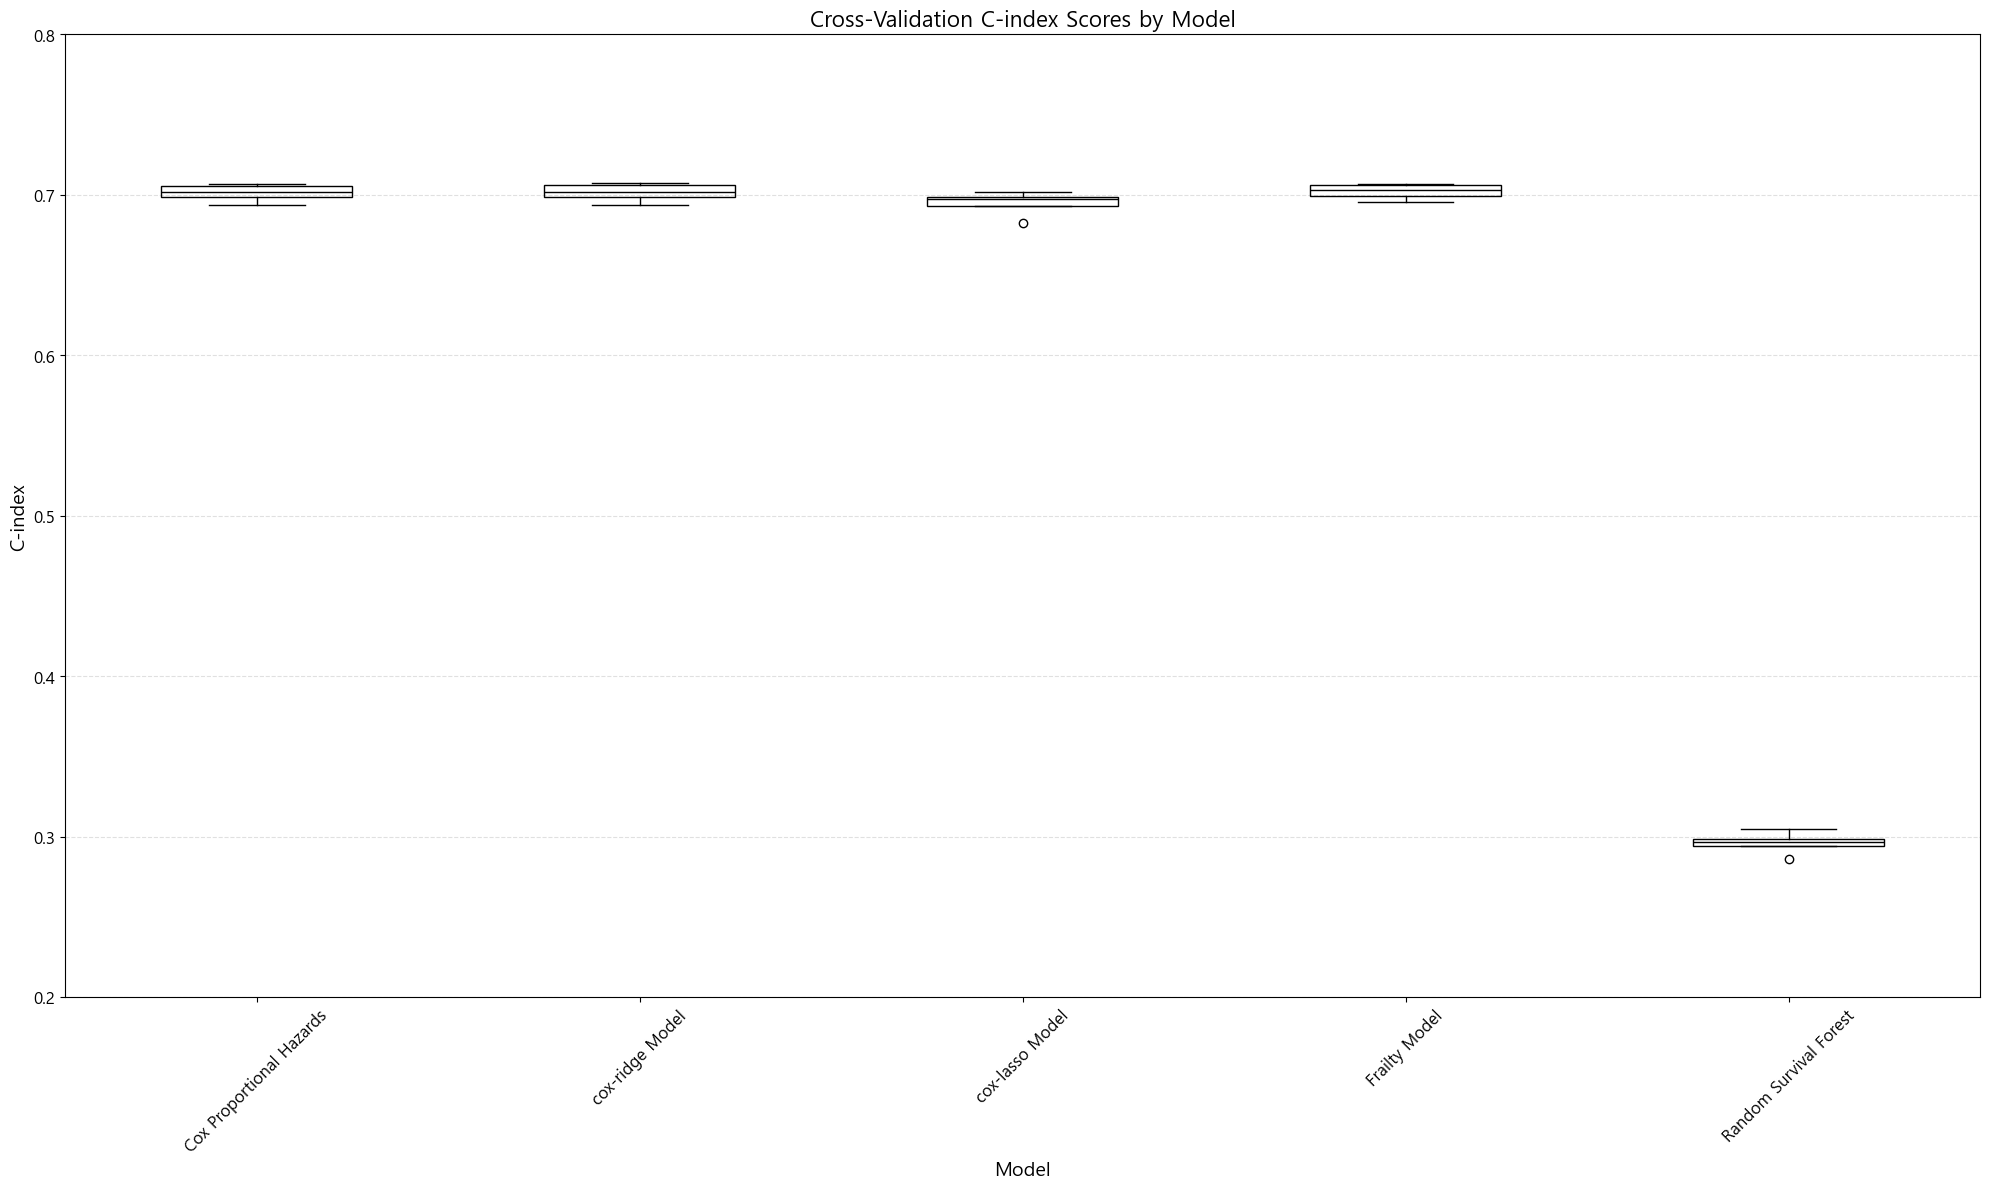

In [27]:
import matplotlib.pyplot as plt

# 각 모델의 C-index 결과와 모델 이름
results = [
    cox_c_indices,
    ridge_c_indices,
    lasso_c_indices,
    frailty_c_indices,
    rsf_c_indices,
]
model_name = [
    "Cox Proportional Hazards",
    "cox-ridge Model",
    "cox-lasso Model",
    "Frailty Model",
    "Random Survival Forest",
]

# 결과 시각화
plt.figure(figsize=(20, 12), facecolor="white")  # 전체 배경색을 하얗게 설정
box = plt.boxplot(
    results,
    patch_artist=True,  # 박스 스타일을 사용자 정의할 수 있도록 설정
    labels=model_name,
    boxprops=dict(color="black"),  # 박스 테두리를 검정색으로 설정
    medianprops=dict(color="black"),  # 중앙선을 검정색으로 설정
    whiskerprops=dict(color="black"),  # 수염을 검정색으로 설정
    capprops=dict(color="black"),  # 캡을 검정색으로 설정
    flierprops=dict(markerfacecolor="white", markeredgecolor="black"),  # 아웃라이어 스타일
)

# 박스 안의 색상을 제거
for patch in box["boxes"]:
    patch.set_facecolor("none")

# 축의 색깔 설정
ax = plt.gca()  # 현재 축 가져오기
ax.spines["bottom"].set_color("black")  # 아래쪽 X축 색깔 설정
ax.spines["left"].set_color("black")  # 왼쪽 Y축 색깔 설정
ax.spines["top"].set_color("black")  # 위쪽 축 색깔 설정
ax.spines["right"].set_color("black")  # 오른쪽 축 색깔 설정

# 축 눈금 색상 설정
ax.tick_params(axis="x", colors="black")  # X축 눈금 색상
ax.tick_params(axis="y", colors="black")  # Y축 눈금 색상

# 그래프 제목 및 축 설정
plt.title("Cross-Validation C-index Scores by Model", color="black", fontsize=16)
plt.xlabel("Model", color="black", fontsize=14)
plt.ylabel("C-index", color="black", fontsize=14)

# y축 범위 조정
plt.ylim(0.2, 0.8)

# 눈금 스타일 설정
plt.xticks(fontsize=12, color="black", rotation=45)
plt.yticks(fontsize=12, color="black")

# 격자선 설정
plt.grid(axis="y", linestyle="--", color="lightgray", alpha=0.7)  # 회색 격자선 추가

# 그래프 출력
plt.tight_layout()
plt.show()


## 치료 조합의 효과 분석 코드
* 치료조합(tx_1 ~ tx_5)이 생존율에 미치는 영향을 분석하기 위해서 각 치료 조합을 새로운 변수로 생성한 후 cox-ph 모델을 적용하여서 효과를 분석.

In [ ]:
from lifelines import CoxPHFitter
import pandas as pd

data = pd.read_csv(
    "C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0
)  # 데이터 로드
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]

# 치료 조합 변수 생성
data["tx_combination"] = (
    data["tx_1"].astype(str)
    + "_"
    + data["tx_2"].astype(str)
    + "_"
    + data["tx_3"].astype(str)
    + "_"
    + data["tx_4"].astype(str)
    + "_"
    + data["tx_5"].astype(str)
)

# Cox-PH 모델 적합
coxph = CoxPHFitter(penalizer=0.1)
coxph.fit(data, duration_col="stime", event_col="event_inc")
coxph.print_summary()  # 각 치료 조합의 회귀 계수와 p-value 확인

<lifelines.CoxPHFitter: fitted with 33976 total observations, 19331 right-censored observations>
             duration col = 'stime'
                event col = 'event_inc'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 33976
number of events observed = 14645
   partial log-likelihood = -142981.83
         time fit was run = 2025-01-04 15:20:53 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
tx_1           -0.59      0.55      0.03           -0.65           -0.53                0.52                0.59
tx_2            0.00      1.00      0.02           -0.03            0.03                0.97                1.03
tx_3           -0.31      0.74      0.03           -0.36           -0.25                0.70                0.78
tx_4            0.04      1.04      0.06           -0.09            0.17                0.91                1.18
tx_5           -0.36      0.70      0.38           -1.12            0.39                0.33                1.48
seer_TF         0.82      2.26      0.02            0.78            0.85                2.19                2.34
gu_encoded      0.00      1.00      0.00           -0.00            0.00                1.00                1.00
tx_combination -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00

                cmp to      z      p  -log2(p)
covariate                                     
tx_1              0.00 -19.23 <0.005    271.28
tx_2              0.00   0.10   0.92      0.12
tx_3              0.00 -11.19 <0.005     94.23
tx_4              0.00   0.58   0.56      0.83
tx_5              0.00  -0.94   0.35      1.53
seer_TF           0.00  47.44 <0.005       inf
gu_encoded        0.00   0.41   0.68      0.56
tx_combination    0.00 -19.10 <0.005    267.65
---
Concordance = 0.70
Partial AIC = 285979.67
log-likelihood ratio test = 6093.03 on 8 df
-log2(p) of ll-ratio test = inf

## Frailty 모델을 활용한 지역별 변량효과 분석
* 지역 간 생존 시간의 차이를 확인

In [2]:
from lifelines import CoxPHFitter
import pandas as pd

data = pd.read_csv(
    "C:/Users/user/Desktop/survival_data/DISEASE/colon.csv", index_col=0
)  # 데이터 로드
data = data[
    [
        "stime",
        "event_inc",
        "tx_1",
        "tx_2",
        "tx_3",
        "tx_4",
        "tx_5",
        "seer_TF",
        "gu_encoded",
    ]
]
# Frailty 모델 적합
frailty_model = CoxPHFitter()
frailty_model.fit(
    data,
    duration_col="stime",
    event_col="event_inc",
    strata=["gu_encoded"],  # 지역별로 Frailty 적용
)
frailty_model.print_summary()

# 지역별 변량효과 추출
frailty_effects = frailty_model.baseline_cumulative_hazard_  # Frailty 효과 확인
print(frailty_effects)

<lifelines.CoxPHFitter: fitted with 33976 total observations, 19331 right-censored observations>
             duration col = 'stime'
                event col = 'event_inc'
                   strata = gu_encoded
      baseline estimation = breslow
   number of observations = 33976
number of events observed = 14645
   partial log-likelihood = -103370.16
         time fit was run = 2025-01-06 01:30:15 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
tx_1      -1.32      0.27      0.02           -1.36           -1.29                0.26                0.28
tx_2      -0.13      0.88      0.02           -0.17           -0.09                0.85                0.91
tx_3      -0.43      0.65      0.03           -0.49           -0.37                0.61                0.69
tx_4       0.02      1.02      0.07           -0.12            0.16                0.89                1.17
tx_5      -0.50      0.61      0.45           -1.38            0.38                0.25                1.46
seer_TF    1.10      3.00      0.02            1.06            1.14                2.88                3.13

           cmp to      z      p  -log2(p)
covariate                                
tx_1         0.00 -73.48 <0.005       inf
tx_2         0.00  -6.97 <0.005     38.23
tx_3         0.00 -13.78 <0.005    141.16
tx_4         0.00   0.27   0.79      0.35
tx_5         0.00  -1.12   0.26      1.93
seer_TF      0.00  52.45 <0.005       inf
---
Concordance = 0.70
Partial AIC = 206752.32
log-likelihood ratio test = 7238.70 on 6 df
-log2(p) of ll-ratio test = inf

             0         1         2         3         4         5         6   \
0.0    0.006497  0.006105  0.002272  0.006027  0.005191  0.008253  0.005441   
1.0    0.025418  0.021128  0.012962  0.020506  0.021527  0.018348  0.017717   
2.0    0.034730  0.031682  0.024843  0.032037  0.039469  0.026719  0.030264   
3.0    0.040734  0.045090  0.031442  0.041850  0.058596  0.037706  0.040660   
4.0    0.048111  0.054958  0.036487  0.051424  0.069401  0.047618  0.051387   
...         ...       ...       ...       ...       ...       ...       ...   
272.0  0.890740  0.906948  0.826744  0.877961  0.877234  0.833722  0.928156   
276.0  0.890740  0.906948  0.826744  0.877961  0.877234  0.833722  0.928156   
288.0  0.890740  0.906948  0.826744  0.877961  0.877234  0.833722  0.928156   
296.0  0.890740  0.906948  0.826744  0.877961  0.877234  0.833722  0.928156   
298.0  0.890740  0.906948  0.826744  0.877961  0.877234  0.833722  0.928156   

             7         8         9         10      

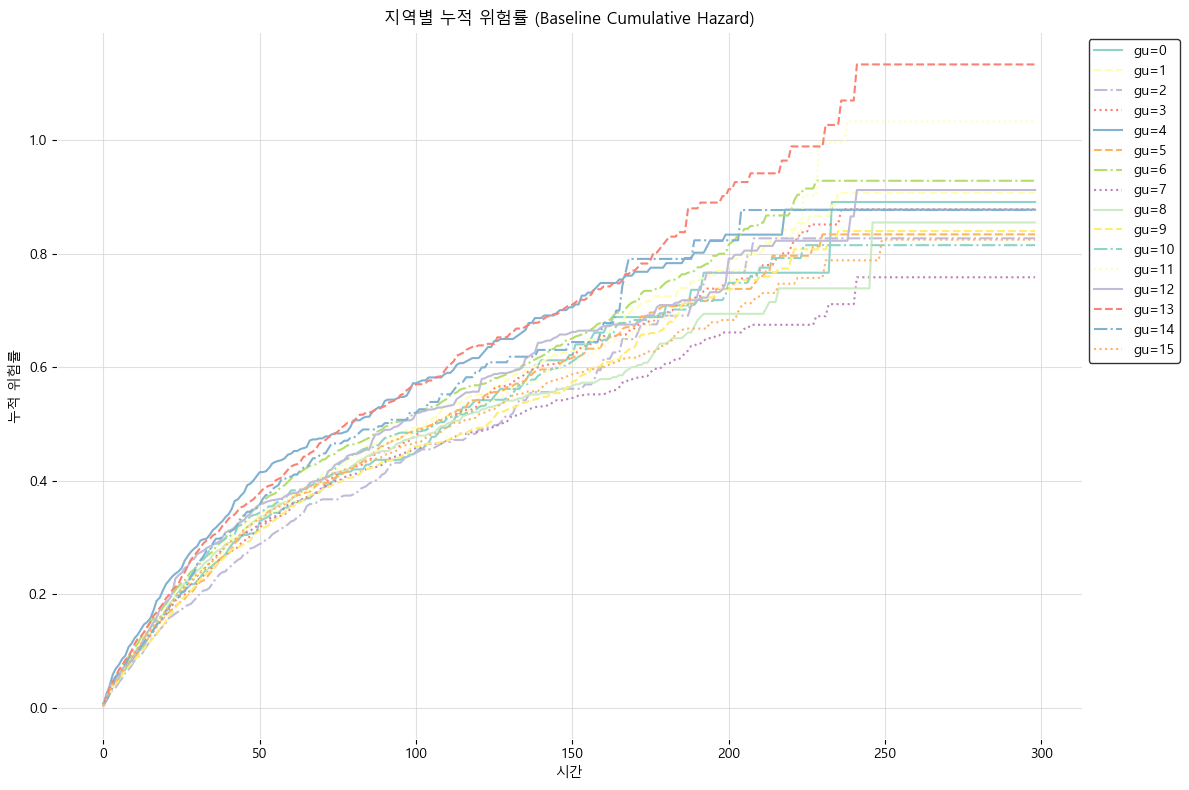

In [ ]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
plt.rcParams["axes.facecolor"] = "white"  # 축 배경색을 하얀색으로 설정
plt.rcParams["text.color"] = "black"  # 텍스트 색상을 검정색으로 설정
plt.rcParams["axes.labelcolor"] = "black"  # x, y 축 라벨 색상
plt.rcParams["xtick.color"] = "black"  # x축 눈금 색상
plt.rcParams["ytick.color"] = "black"  # y축 눈금 색상
plt.rcParams["legend.edgecolor"] = "black"  # 범례 테두리 색상

# 지역별 누적 위험률 시각화
frailty_effects = frailty_model.baseline_cumulative_hazard_

# 선 종류 리스트 (순환 사용)
linestyles = ["-", "--", "-.", ":"]
plt.figure(figsize=(12, 8), facecolor="white")  # 전체 figure 배경색을 하얀색으로 설정

for idx, gu in enumerate(frailty_effects.columns):  # 각 지역이 컬럼에 있음
    plt.plot(
        frailty_effects.index,
        frailty_effects[gu],
        label=f"gu={gu}",
        linestyle=linestyles[idx % len(linestyles)],  # 선 종류를 순환 적용
    )

# 제목, 축 라벨, 범례 설정
plt.title("지역별 누적 위험률 (Baseline Cumulative Hazard)", color="black")
plt.xlabel("시간", color="black")
plt.ylabel("누적 위험률", color="black")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), facecolor="white", edgecolor="black")  # 범례 배경을 하얀색으로 설정

# 격자 스타일 설정
plt.grid(color="lightgray", alpha=0.7)  # 격자선을 연한 회색으로 설정
plt.tight_layout()
plt.show()


## 전이에 따른 생존시간

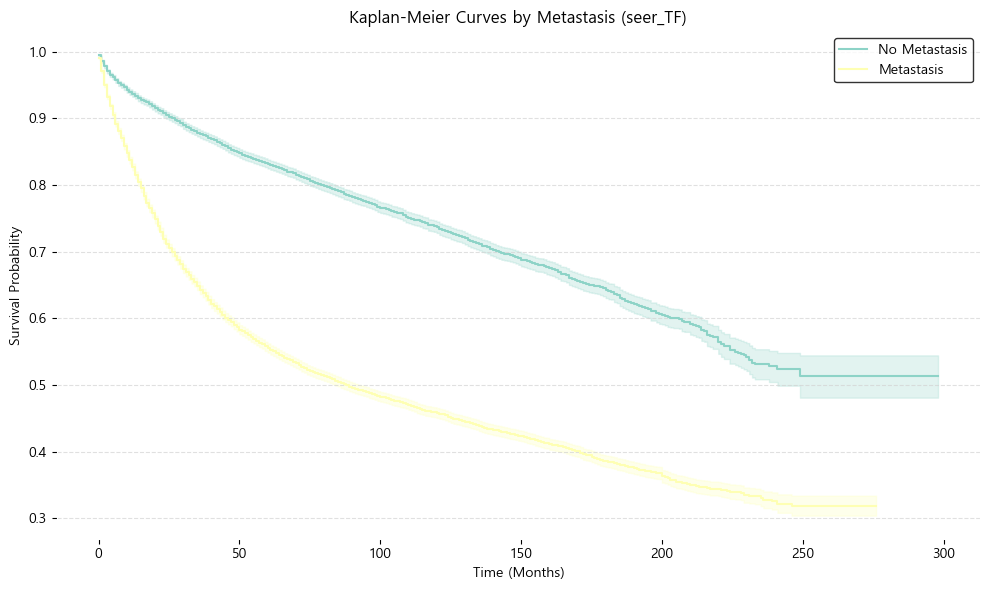

Log-Rank Test p-value: 0.0


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호 깨짐 방지
plt.rcParams["axes.facecolor"] = "white"  # 축 배경색을 하얀색으로 설정
plt.rcParams["text.color"] = "black"  # 텍스트 색상을 검정색으로 설정
plt.rcParams["axes.labelcolor"] = "black"  # x, y 축 라벨 색상
plt.rcParams["xtick.color"] = "black"  # x축 눈금 색상
plt.rcParams["ytick.color"] = "black"  # y축 눈금 색상
plt.rcParams["legend.edgecolor"] = "black"  # 범례 테두리 색상

# Kaplan-Meier 곡선
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6), facecolor="white")  # 전체 배경을 하얀색으로 설정

# 전이가 없는 그룹
non_metastasis = data[data["seer_TF"] == 0]
kmf.fit(
    non_metastasis["stime"],
    event_observed=non_metastasis["event_inc"],
    label="No Metastasis",
)
kmf.plot_survival_function(ci_show=True)

# 전이가 있는 그룹
metastasis = data[data["seer_TF"] == 1]
kmf.fit(metastasis["stime"], event_observed=metastasis["event_inc"], label="Metastasis")
kmf.plot_survival_function(ci_show=True)

# 그래프 꾸미기
plt.title("Kaplan-Meier Curves by Metastasis (seer_TF)", color="black")
plt.xlabel("Time (Months)", color="black")
plt.ylabel("Survival Probability", color="black")
plt.legend(
    loc="best", facecolor="white", edgecolor="black"
)  # 범례 배경과 테두리 설정
plt.grid(axis="y", linestyle="--", color="lightgray", alpha=0.7)  # 격자 스타일 설정
plt.tight_layout()
plt.show()

# Log-Rank Test
logrank_result = logrank_test(
    non_metastasis["stime"],
    metastasis["stime"],
    event_observed_A=non_metastasis["event_inc"],
    event_observed_B=metastasis["event_inc"],
)
print("Log-Rank Test p-value:", logrank_result.p_value)


수술, 화학요법, 방사선요법, 면역요법, 호르몬요법, 기타